# Κατασκευή Νευρωνικού Δικτύου

***

### Εισαγωγή δεδομένων

Για αρχή θα πειραματιστούμε με τα data από το simulation και πολύ απλοϊκά μοντέλα με λίγες παραμέτρους.

Παίρνουμε τα data στα οποία έχουμε εφαρμόσει γραμμική παρεμβολή και δημιουργούμε τα labels που πρέπει τελικά να εντοπιστούν στην μορφή $[x_l, y_l]$

In [1]:
import sklearn.neural_network
import torch
import sklearn
import pandas as pd
import numpy as np
#import ast
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
Data = pd.read_pickle("Sim_Data_Noisy_Interp.pkl")

rfid_label = (Data['x_tag'], Data['y_tag'])
rfid_label = np.array(rfid_label).T
print(rfid_label.shape)

(1000, 2)


Έπειτα δημιουργούμε έναν πίνακα (tensor) διαστάσεων $(1000, 1000, 4)$ που περιέχει τα 1000 tags που δημιουργήθηκαν από το simulation, τα 1000 time samples από το μήκος των μετρήσεων, και τα 4 χαρακτηριστικά που μας χρειάζονται , [x_robot,y_robot,z_robot,phase_unwrapped].

In [3]:
info_tensor = np.empty((0, 1000, 4))
for i in range(len(rfid_label)):
    Data.loc[i, 'Phases'] = Data.loc[i, 'Phases'].reshape(-1, 1)
    result = np.concatenate((Data.loc[i, 'robot_pos'].T, Data.loc[i, 'Phases'].reshape(-1, 1)), axis=1)
    info_tensor = np.concatenate((info_tensor, result[np.newaxis, :, :]), axis=0)

print(info_tensor.shape)

(1000, 1000, 4)


***

### Data Augmentation μέσω segmentation

Ορίζουμε την συνάρτηση παρακάτω μέσω της οποίας μετασχηματίζουμε κάθε μία μέτρηση σε ένα πλήθος x που μπορούμε να διαλέξουμε εμείς με y αριθμό μετρήσεων στο κάθε ένα. Αυτό συμβαίνει καθώς για κάθε ένα tag σπάμε τις μετρήσεις σε x (όχι απαραίτητα μη επικαλυπτόμενες) μετρήσεις μεγέθους y.

In [51]:
#Take random segments of the full array
def sample_random_segments(tensor1, segment_length, num_samples):
    if len(tensor1) < segment_length:
        raise ValueError("Segment length must be smaller than or equal to array length.")
    
    max_start_index = len(tensor1) - segment_length  # Ensure segment stays within bounds
    start_indices = np.random.randint(0, max_start_index + 1, size=num_samples)

    segments = np.empty((num_samples, segment_length, tensor1.shape[1]))

    for idx, start in enumerate(start_indices):
        segments[idx] = tensor1[start:start+segment_length]
    return segments

In [58]:
num_of_samples = 5
segment_length = 200

info_new = np.empty((0, segment_length, 4))
for i in range(len(info_tensor)):
    temp_info = sample_random_segments(info_tensor[i], segment_length, num_of_samples) 
    info_new = np.concatenate((info_new, temp_info), axis=0)

# Multiply labels
rfid_label = np.repeat(rfid_label, num_of_samples, axis=0)

In [60]:
print(info_new.shape)
print(rfid_label.shape)

(5000, 200, 4)
(5000, 2)


***

### Προβλέψεις μέσω XGB

Τo XGB δεν υποστηρίζει πολυδιάστατη είσοδο όπως θα θέλαμε καθώς υπάρχει χρονική συσχέτιση μεταξύ των δεδομένων. Επίσης δεν υποστηρίζει πολυδιάστατη έξοδο, δηλαδή δεν μπορεί να υπολογίσει και το X και το Y του tag. Για αυτά τα προβλήματα προχωράμε στις παρακάτω λύσεις

- Κάνουμε *flatten* τον πίνακα των δεδομένων εισόδου
- Χρησιμοποιούμε το module *MultiOutputRegressor* για να διαχειριστούμε πολλαπλές εξόδους.

In [65]:
# Reshape the tensor to 2D so that it can be used in the XGB model
X = info_new.reshape(len(info_new), -1)
print(X.shape)

(5000, 800)


In [66]:
y = rfid_label
print(y.shape)

(5000, 2)


Προετοιμάζουμε τα training και test data.

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(4000, 800)
(1000, 800)


Κάνουμε train το μοντέλο και ελέγχουμε τις προβλέψεις του.

In [71]:
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1000, learning_rate=0.01)

# Fit the model
multi_xgb = MultiOutputRegressor(xgb_model)
multi_xgb.fit(X_train_scaled, y_train) 

# Predict the model
y_pred = multi_xgb.predict(X_test_scaled)

In [72]:
# Calculate the error
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
print("RMSE:", rmse)

mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print("MAE:", mae)

# Euclidean Distance metric
distance_error = np.linalg.norm(y_test - y_pred, axis=1)
print("Mean Distance Error:", np.mean(distance_error))

RMSE: [0.14690411 0.13649753]
MAE: [0.10788632 0.08291776]
Mean Distance Error: 0.15109934230678415


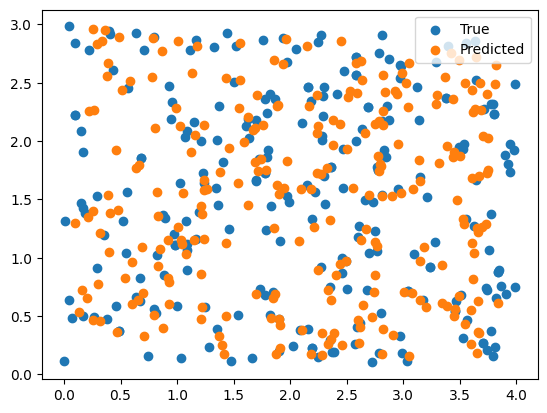

In [73]:
# Plot the results
plt.scatter(y_test[:250, 0], y_test[:250, 1], label='True')
plt.scatter(y_pred[:250, 0], y_pred[:250, 1], label='Predicted')
plt.legend()
plt.show()

***